### Scikit-Learn in Julia

This notebook shows how we can use ScikitLearn library for various kinds of classification tasks. In this demo, we show how various types of classifiers work on some randomly generated data points. 

** Credits **

The original author : (Cédric St-Jean)[https://github.com/cstjean]

[Source](https://github.com/cstjean/ScikitLearn.jl/tree/master/examples)

In [1]:
using ScikitLearn
using PyCall
using PyPlot
using ScikitLearn.CrossValidation: train_test_split
@pyimport matplotlib.colors as mplc
@sk_import preprocessing: StandardScaler
@sk_import datasets: (make_moons, make_circles, make_classification)
@sk_import neighbors: KNeighborsClassifier
@sk_import svm: SVC
@sk_import tree: DecisionTreeClassifier
@sk_import ensemble: (RandomForestClassifier, AdaBoostClassifier)
@sk_import naive_bayes: GaussianNB
@sk_import discriminant_analysis: (LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis)
using ScikitLearn.Utils: meshgrid

INFO: Recompiling stale cache file C:\Windows\ServiceProfiles\LocalService\.julia\lib\v0.5\ScikitLearn.ji for module ScikitLearn.


In [2]:
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
srand(42)
X += 2 * rand(size(X)...)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ];

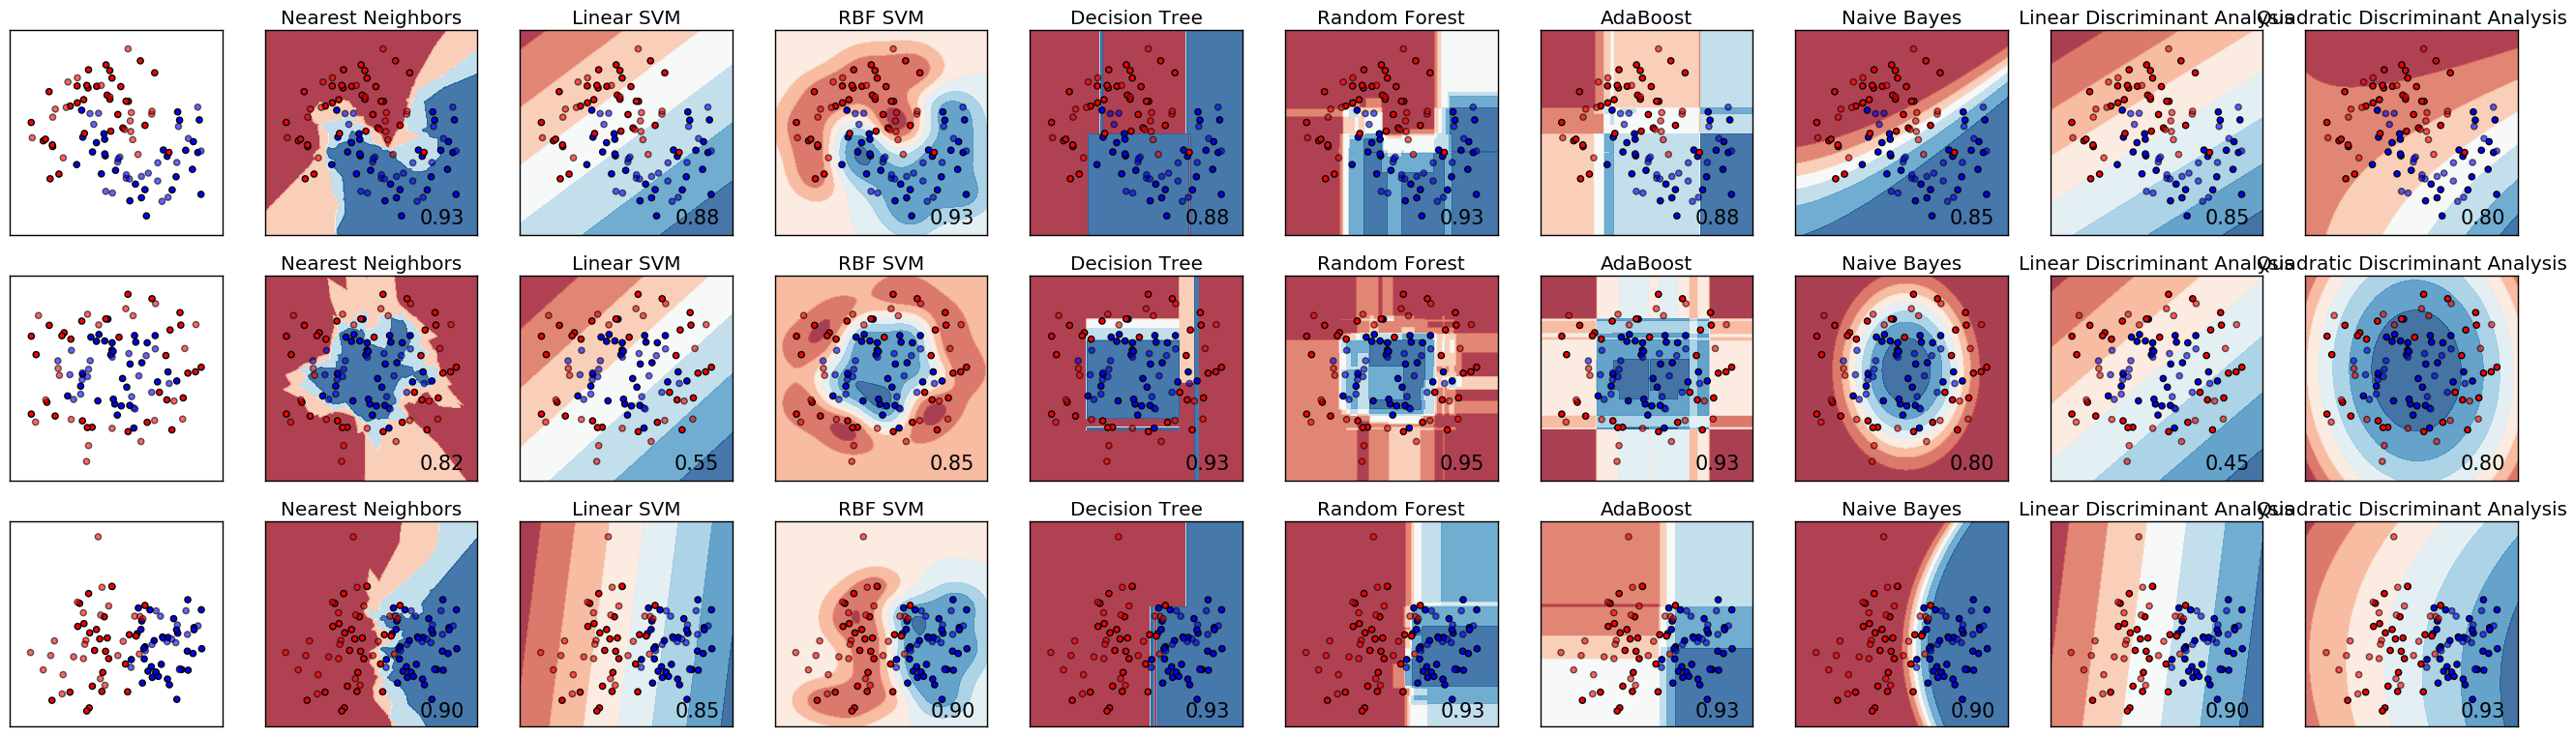

In [3]:
fig = figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds in datasets
    # preprocess dataset, split into training and test part
    X, y = ds
    X = fit_transform!(StandardScaler(), X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = minimum(X[:, 1]) - .5, maximum(X[:, 1]) + .5
    y_min, y_max = minimum(X[:, 2]) - .5, maximum(X[:, 2]) + .5
    xx, yy = meshgrid(x_min:h:x_max, y_min:h:y_max)

    # just plot the dataset first
    cm = PyPlot.cm[:RdBu]
    cm_bright = mplc.ListedColormap(["#FF0000", "#0000FF"])
    ax = subplot(length(datasets), length(classifiers) + 1, i)
    # Plot the training points
    ax[:scatter](X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright)
    # and testing points
    ax[:scatter](X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright, alpha=0.6)

    ax[:set_xlim](minimum(xx), maximum(xx))
    ax[:set_ylim](minimum(yy), maximum(yy))
    ax[:set_xticks](())
    ax[:set_yticks](())
    i += 1

    # iterate over classifiers
    for (name, clf) in zip(names, classifiers)
        ax = subplot(length(datasets), length(classifiers) + 1, i)
        fit!(clf, X_train, y_train)
        scor = score(clf, X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        try 
            # Not implemented for some
            Z = decision_function(clf, hcat(xx[:], yy[:]))
        catch
            Z = predict_proba(clf, hcat(xx[:], yy[:]))[:, 2]
        end

        # Put the result into a color plot
        Z = reshape(Z, size(xx)...)
        ax[:contourf](xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax[:scatter](X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright)
        # and testing points
        ax[:scatter](X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax[:set_xlim](minimum(xx), maximum(xx))
        ax[:set_ylim](minimum(yy), maximum(yy))
        ax[:set_xticks](())
        ax[:set_yticks](())
        ax[:set_title](name)

        ax[:text](maximum(xx) - .3, minimum(yy) + .3, @sprintf("%.2f", scor),
                size=15, horizontalalignment="right")
        i += 1
    end
end
fig[:subplots_adjust](left=.02, right=.98)

In the above grid shows the test data in the first column, and the classifications in the subsequent columns using various types of classifiers.